In [1]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (GPT2Tokenizer, GPT2Model, 
                          set_seed,
                          training_args,
                          trainer,
                          GPT2Config,
                          AdamW,
                          get_cosine_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)
# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs=4
# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'BIT': 0, 'BPMAI': 1, 'Camunda':2, 'eCH':3}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [10]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
from tqdm import tqdm

class BPMNDomainDataset(Dataset):
    
    def __init__(self, path):

        # Check if path exists.
        if not os.path.isfile(path):
            # Raise error if path is invalid.
            raise ValueError('Invalid `path` variable! Needs to be a file')
        
        # Load data from CSV
        self.df = pd.read_csv(path, sep=';', engine='python', encoding='utf-8')

        # Extract descriptions and domains
        self.descriptions = self.df['Labels'].to_list()
        self.domains = self.df['CollectionName'].to_list()

        # Flatten the list of labels
        self.flattened_domains = [label for sublist in self.domains for label in eval(sublist)]

        # Number of examples
        self.n_examples = len(self.descriptions)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text': self.descriptions[item], 'label': self.flattened_domains[item]}  # Use flattened list of labels

class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]  # 'text' instead of 'labels'
        domains = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in domains]  # Encoding domains as labels
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels': torch.tensor(labels)})
        return inputs

def train(model, dataloader, optimizer, scheduler, device):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.train()
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_, model):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.eval()
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content
    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

In [11]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Model loaded to `cpu`


In [12]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, labels_encoder=labels_ids, max_sequence_len=max_length)

print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = BPMNDomainDataset(path='./BPMNtraining.csv')
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset = BPMNDomainDataset(path='./BPMNtesting.csv')
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 8718 examples!
Created `train_dataloader` with 273 batches!
Dealing with Validation...
Created `valid_dataset` with 3735 examples!
Created `eval_dataloader` with 117 batches!


/Users/anthonyeleuteri/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|                                                                | 0/4 [00:00<?, ?it/s]


Training on batches...



 31%|████████████████▌                                    | 85/273 [02:37<05:45,  1.84s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:14<03:03,  1.80s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [07:55<00:28,  1.81s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:24<00:00,  1.85s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:44<00:16,  1.93it/s]


 25%|█████████████▊                                         | 1/4 [09:26<28:18, 566.15s/it]

  train_loss: 0.19731 - val_loss: 0.03541 - train_acc: 0.93863 - valid_acc: 0.99116

Training on batches...



 31%|████████████████▌                                    | 85/273 [02:36<05:46,  1.84s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:13<03:07,  1.83s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [07:53<00:29,  1.83s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:22<00:00,  1.84s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:43<00:16,  1.96it/s]


 50%|███████████████████████████▌                           | 2/4 [18:48<18:47, 563.73s/it]

  train_loss: 0.05070 - val_loss: 0.03698 - train_acc: 0.98750 - valid_acc: 0.99197

Training on batches...



 31%|████████████████▌                                    | 85/273 [02:40<06:03,  1.93s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:20<03:21,  1.97s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [08:03<00:30,  1.88s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:33<00:00,  1.88s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:45<00:17,  1.80it/s]


 75%|█████████████████████████████████████████▎             | 3/4 [28:24<09:29, 569.62s/it]

  train_loss: 0.02708 - val_loss: 0.03192 - train_acc: 0.99426 - valid_acc: 0.99357

Training on batches...



 31%|████████████████▌                                    | 85/273 [02:42<05:43,  1.83s/it]


 63%|████████████████████████████████▌                   | 171/273 [05:25<03:15,  1.92s/it]


 94%|████████████████████████████████████████████████▉   | 257/273 [08:10<00:31,  1.96s/it]


100%|████████████████████████████████████████████████████| 273/273 [08:39<00:00,  1.90s/it]


Validation on batches...



 73%|██████████████████████████████████████▌              | 85/117 [00:48<00:19,  1.67it/s]


100%|███████████████████████████████████████████████████████| 4/4 [38:11<00:00, 572.75s/it]
/Users/anthonyeleuteri/anaconda3/lib/python3.11/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


  train_loss: 0.02412 - val_loss: 0.03073 - train_acc: 0.99518 - valid_acc: 0.99411


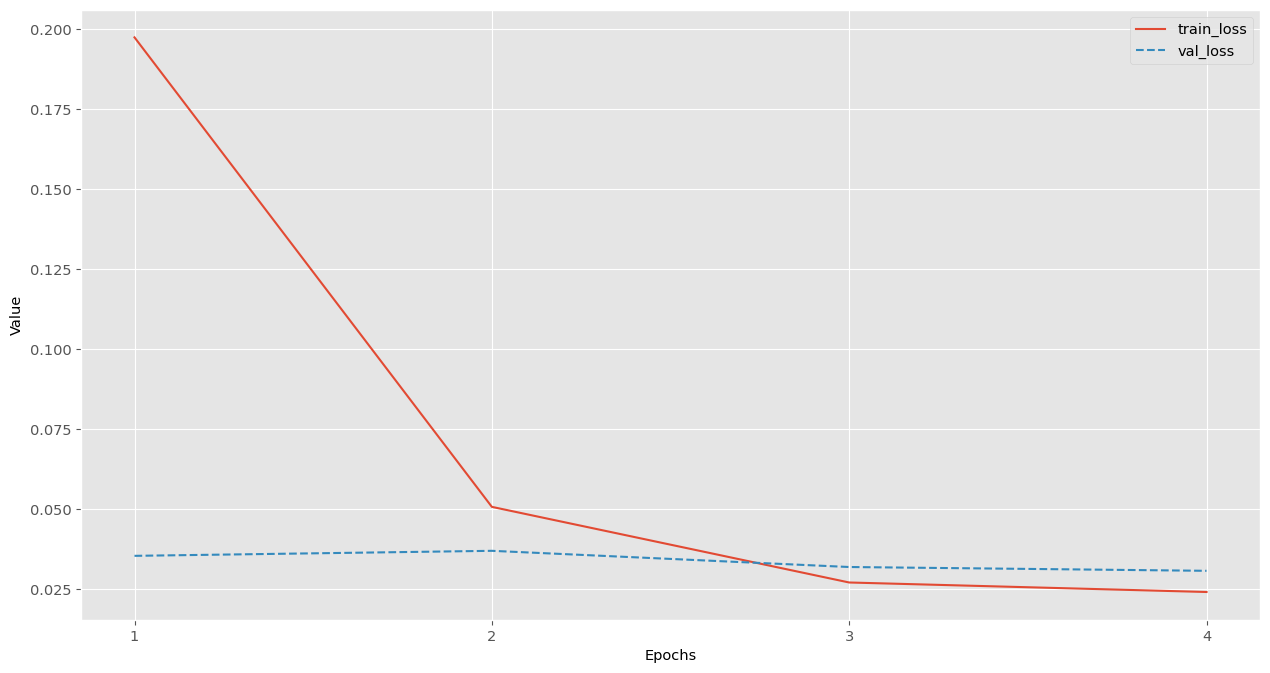

/Users/anthonyeleuteri/anaconda3/lib/python3.11/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


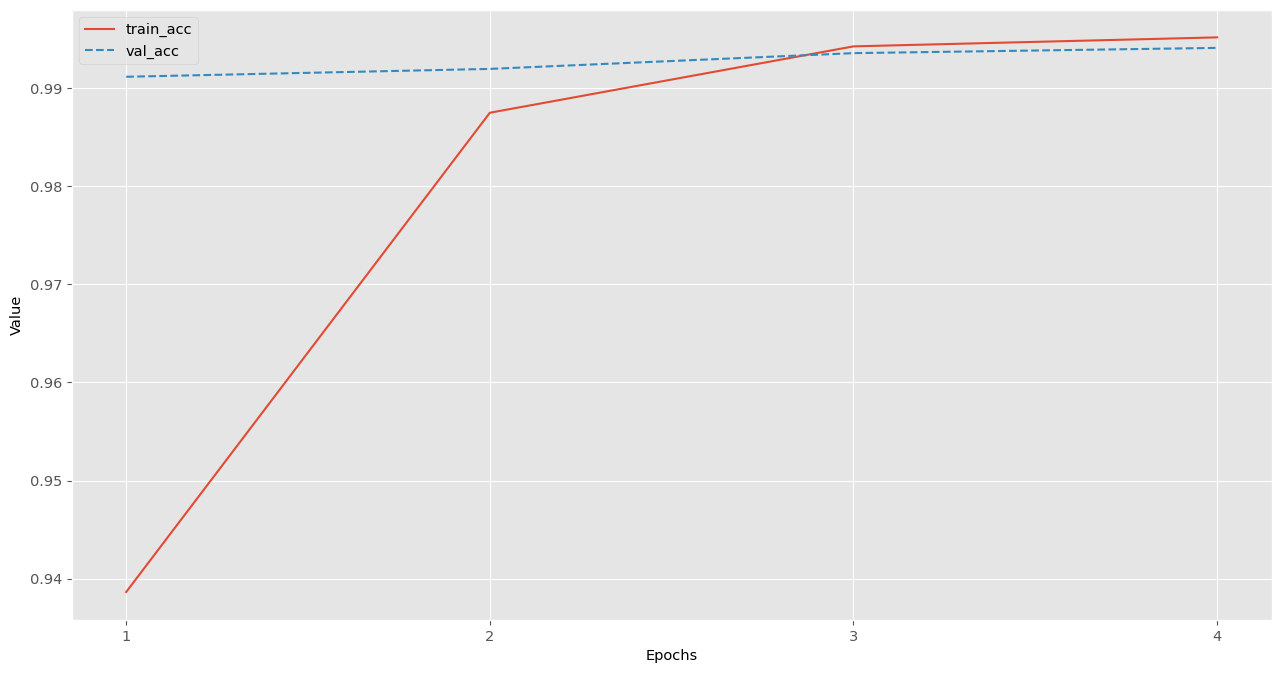

In [13]:
from transformers import AdamW, get_linear_schedule_with_warmup
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # default is 5e-5, our notebook had 2e-5
                  eps=1e-8  # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # Default value in run_glue.py
                                            num_training_steps=total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device, model)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f" % (train_loss, val_loss, train_acc, val_acc))

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
